In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import docx
import os
import datetime
import warnings
import numpy as np
import matplotlib.dates as mdates
import sqlite3
from pathlib import Path

warnings.filterwarnings("ignore")


# 連線到SQLite資料庫
conn = sqlite3.connect(r"D:\SourceCode\DatabaseNet5Pro\Database_Files\MgrSytem.db")

# 從SQLite資料庫讀取整張資料表到DataFrame
df = pd.read_sql_query("SELECT * FROM [二年內逾放明細表(全部)_彙總]", conn)

conn.close()
print("DataFrame has been loaded from the SQLite database.")
print(f"資料筆數: {len(df)}")
print(df.head())

DataFrame has been loaded from the SQLite database.
資料筆數: 5115
      期別 分行代號  分行名稱  逾期放款中_最近2年內貸放之放款_(百萬元)  佔列報逾期放_款總額之比率  佔放款總額之比率
0  10903  009  臺南分行               10.630161       0.050000  0.000103
1  10903  011  高雄分行                0.253262       0.009856  0.000003
2  10903  018  花蓮分行                0.385233       0.012902  0.000032
3  10903  024  澎湖分行                1.037536       0.200578  0.000221
4  10903  026  桃園分行                8.535543       0.220590  0.000104


In [72]:
# 將期別(YYYMM,民國年月)轉換為西元日期
def tw_to_ad(tw_date):
    tw_date = str(tw_date)
    if len(tw_date) == 5:  # 例如：11212
        year = int(tw_date[:3]) + 1911  # 112 + 1911 = 2023
        month = tw_date[3:]             # 12
        return f"{year}{month.zfill(2)}"
    elif len(tw_date) == 6:  # 例如：112012
        year = int(tw_date[:3]) + 1911  # 112 + 1911 = 2023
        month = tw_date[3:]             # 012
        return f"{year}{month[-2:].zfill(2)}"  # 取後兩位作為月份
    else:
        return tw_date

In [73]:
# 轉換期別
df['西元期別'] = df['期別'].apply(tw_to_ad)

# 轉換成日期格式
df['期別日期'] = pd.to_datetime(df['西元期別'], format='%Y%m') + pd.offsets.MonthEnd(0)


In [74]:
#取得最新期別日期的佔放款總額之比率前十名資料
latest_date = df['期別日期'].max()
top_10 = df[df['期別日期'] == latest_date].nlargest(10, '佔放款總額之比率')
print(top_10)

         期別 分行代號      分行名稱  逾期放款中_最近2年內貸放之放款_(百萬元)  佔列報逾期放_款總額之比率  佔放款總額之比率  \
5094  11407  290  臺中精密園區分行                6.500071       0.529618  0.001428   
5095  11407  272     六甲頂分行               22.355156       0.256770  0.001118   
5096  11407  122      仁愛分行               12.455656       0.470307  0.000905   
5097  11407  028      新營分行                2.938034       0.072543  0.000341   
5098  11407  075      新店分行                2.300099       0.105254  0.000231   
5099  11407  147      虎尾分行                1.898466       0.110422  0.000220   
5100  11407  012      基隆分行                1.465326       0.034732  0.000112   
5101  11407  013    中興新村分行                0.699994       0.021764  0.000090   
5102  11407  014      嘉義分行                1.742935       0.046377  0.000083   
5103  11407  224      高榮分行                1.287587       0.091693  0.000081   

        西元期別       期別日期  
5094  202507 2025-07-31  
5095  202507 2025-07-31  
5096  202507 2025-07-31  
5097  202507 2025-07-31  


In [75]:
# 取得最新期別日期的敘述統計資料
latest_date_stats = df[df['期別日期'] == latest_date].describe()
# 優化敘述統計資料呈現說明
latest_date_stats = latest_date_stats.transpose()
latest_date_stats['IQR'] = latest_date_stats['75%'] - latest_date_stats['25%']
latest_date_stats['Lower Bound'] = latest_date_stats['25%'] - 1.5 * latest_date_stats['IQR']
latest_date_stats['Upper Bound'] = latest_date_stats['75%'] + 1.5 * latest_date_stats['IQR']
print(latest_date_stats)

                       count                 mean                  min  \
逾期放款中_最近2年內貸放之放款_(百萬元)  21.0             2.997375             0.042571   
佔列報逾期放_款總額之比率           21.0             0.123934             0.005429   
佔放款總額之比率                21.0             0.000236             0.000003   
期別日期                      21  2025-07-31 00:00:00  2025-07-31 00:00:00   

                                        25%                  50%  \
逾期放款中_最近2年內貸放之放款_(百萬元)             0.699994             1.465326   
佔列報逾期放_款總額之比率                      0.011346             0.034732   
佔放款總額之比率                           0.000026             0.000071   
期別日期                    2025-07-31 00:00:00  2025-07-31 00:00:00   

                                        75%                  max       std  \
逾期放款中_最近2年內貸放之放款_(百萬元)             2.216897            22.355156  5.225809   
佔列報逾期放_款總額之比率                      0.105254             0.706572  0.198572   
佔放款總額之比率                            0.00022           

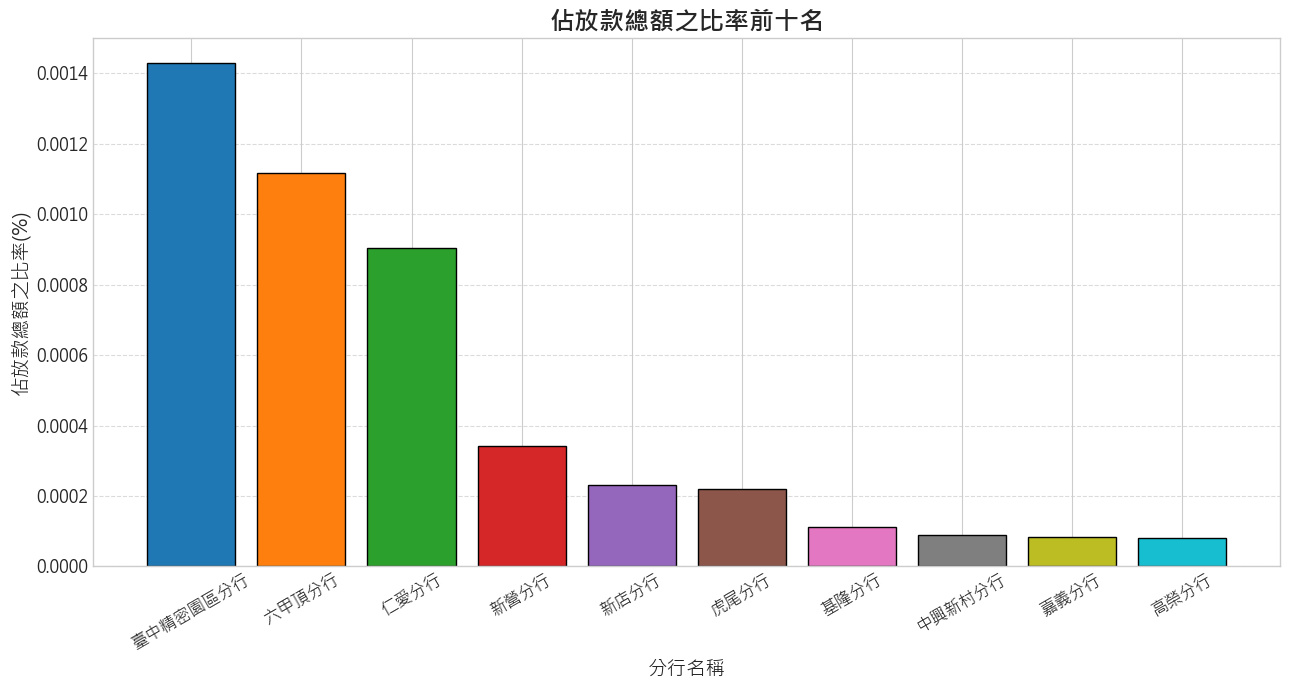

In [76]:
# 畫出佔放款總額之比率前十名的長條圖
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
# 設定中文字型（以微軟正黑體為例，請確認本機有此字型）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(13, 7))
bar_colors = sns.color_palette('tab10', n_colors=len(top_10['分行名稱']))
bars = plt.bar(top_10['分行名稱'], top_10['佔放款總額之比率'], color=bar_colors, edgecolor='black')
plt.title('佔放款總額之比率前十名', fontsize=18, fontweight='bold')
plt.xlabel('分行名稱', fontsize=14)
plt.ylabel('佔放款總額之比率(%)', fontsize=14)
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

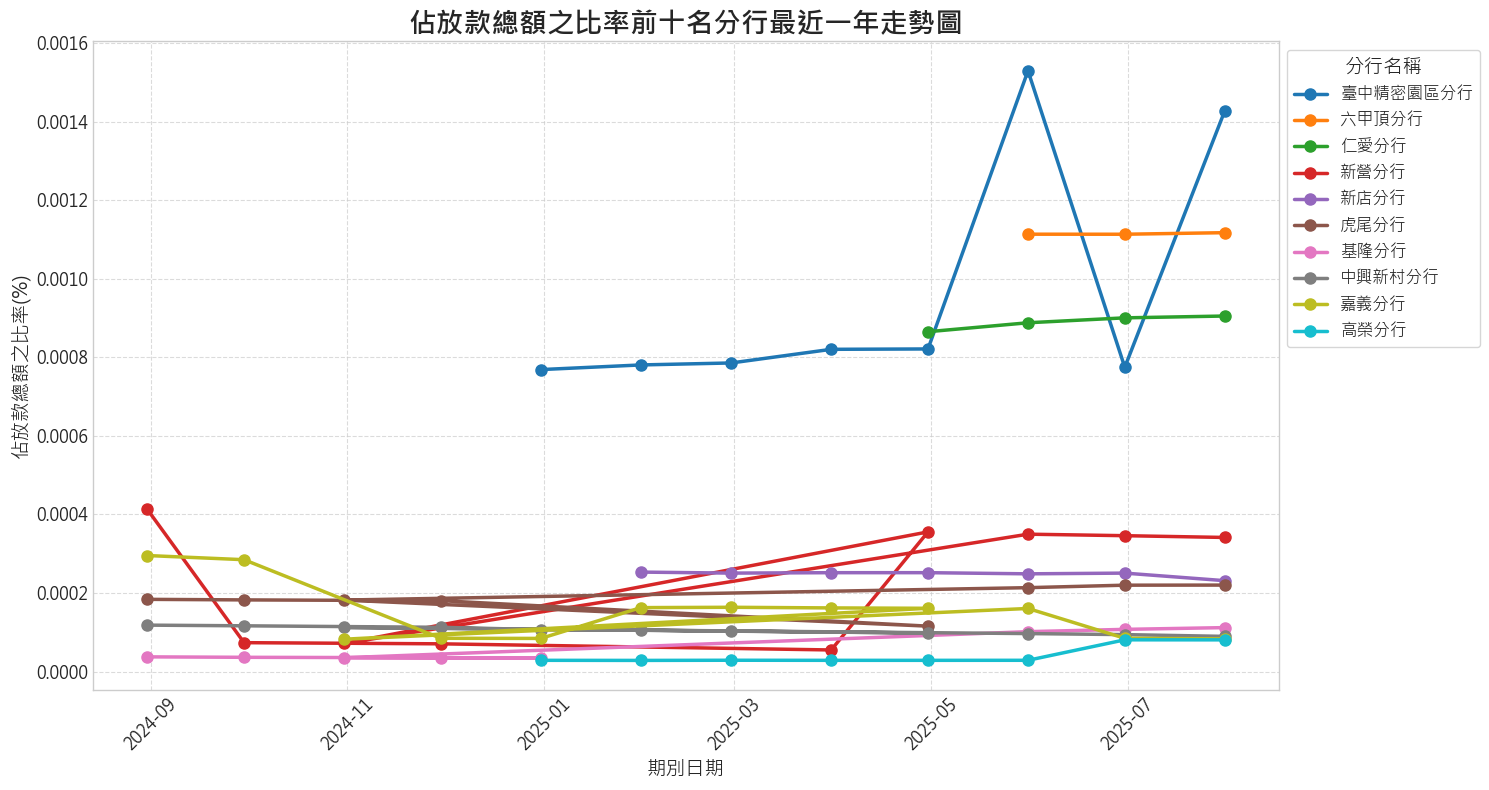

In [77]:
# 取得前十名分行名稱
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
# 設定中文字型（以微軟正黑體為例，請確認本機有此字型）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False
top_10_names = top_10['分行名稱'].tolist()

# 篩選最近一年資料
one_year_ago = latest_date - pd.DateOffset(years=1)
recent_year_df = df[(df['期別日期'] > one_year_ago) & (df['分行名稱'].isin(top_10_names))]

# 美化走勢圖
palette = sns.color_palette('tab10', n_colors=len(top_10_names))
plt.figure(figsize=(15, 8))
for idx, name in enumerate(top_10_names):
    branch_data = recent_year_df[recent_year_df['分行名稱'] == name]
    plt.plot(branch_data['期別日期'], branch_data['佔放款總額之比率'], marker='o', label=name, linewidth=2.5, markersize=8, color=palette[idx])

plt.title('佔放款總額之比率前十名分行最近一年走勢圖', fontsize=20, fontweight='bold')
plt.xlabel('期別日期', fontsize=14)
plt.ylabel('佔放款總額之比率(%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='分行名稱', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, title_fontsize=14, frameon=True)
plt.tight_layout()
plt.show()

In [78]:
# 匯入 Word 文件相關套件
from docx import Document
from docx.shared import Inches, Pt, RGBColor
from docx.enum.text import WD_ALIGN_PARAGRAPH, WD_COLOR_INDEX
from docx.enum.style import WD_STYLE_TYPE
from docx.oxml import OxmlElement
from docx.oxml.ns import qn
from docx.enum.section import WD_SECTION_START
import io
from datetime import datetime

# 設定輸出資料夾（若不存在則建立）
output_dir = "二年內逾放明細表(全部)"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 建立 Word 文件物件
doc = Document()

# 設定頁面邊界和方向
sections = doc.sections
for section in sections:
    section.top_margin = Inches(0.8)
    section.bottom_margin = Inches(0.8)
    section.left_margin = Inches(0.8)
    section.right_margin = Inches(0.8)
    # 設定為橫向頁面
    from docx.enum.section import WD_ORIENT
    section.orientation = WD_ORIENT.LANDSCAPE
    section.page_width = Inches(11)
    section.page_height = Inches(8.5)

# 美化：設定全域字型、大小
style = doc.styles['Normal']
font = style.font
font.name = 'Microsoft JhengHei'
font.size = Pt(11)

# 設定標題樣式
title_style = doc.styles['Heading 1']
title_font = title_style.font
title_font.name = 'Microsoft JhengHei'
title_font.size = Pt(16)
title_font.bold = True
title_font.color.rgb = RGBColor(0, 51, 102)  # 深藍色

# === 封面頁 ===
# 主標題
title_paragraph = doc.add_heading(f"{top_10['期別'].iloc[0]}_二年內逾放明細表(全部)_彙總", 0)
title_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
title_run = title_paragraph.runs[0]
title_run.font.size = Pt(20)
title_run.font.bold = True
title_run.font.color.rgb = RGBColor(0, 51, 102)

# 副標題
subtitle = doc.add_heading('分析報告', level=1)
subtitle.alignment = WD_ALIGN_PARAGRAPH.CENTER
subtitle_run = subtitle.runs[0]
subtitle_run.font.size = Pt(16)
subtitle_run.font.color.rgb = RGBColor(102, 102, 102)

# 空行
for _ in range(3):
    doc.add_paragraph()

# 報告資訊表格
info_table = doc.add_table(rows=4, cols=2)
info_table.style = 'Table Grid'
info_cells = info_table.rows
info_cells[0].cells[0].text = '報告期別'
info_cells[0].cells[1].text = str(top_10['期別'].iloc[0])
info_cells[1].cells[0].text = '報告日期'
info_cells[1].cells[1].text = datetime.now().strftime('%Y年%m月%d日')
info_cells[2].cells[0].text = '資料筆數'
info_cells[2].cells[1].text = f"{len(df):,} 筆"
info_cells[3].cells[0].text = '分析範圍'
info_cells[3].cells[1].text = '全行二年內逾放明細'

# 設定資訊表格樣式
for row in info_table.rows:
    for cell in row.cells:
        cell.paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
        for paragraph in cell.paragraphs:
            for run in paragraph.runs:
                run.font.name = 'Microsoft JhengHei'
                run.font.size = Pt(12)

# 分頁
doc.add_page_break()

# === 設定頁首頁尾 ===
section = doc.sections[0]
header = section.header
footer = section.footer

# 頁首
header_para = header.paragraphs[0]
header_para.text = f"二年內逾放明細表分析報告 - {top_10['期別'].iloc[0]}"
header_para.alignment = WD_ALIGN_PARAGRAPH.CENTER
header_run = header_para.runs[0]
header_run.font.name = 'Microsoft JhengHei'
header_run.font.size = Pt(9)
header_run.font.color.rgb = RGBColor(102, 102, 102)

# 頁尾
footer_para = footer.paragraphs[0]
footer_para.text = f"機密文件 - 僅供內部分析使用 | 報告產製日期: {datetime.now().strftime('%Y/%m/%d')}"
footer_para.alignment = WD_ALIGN_PARAGRAPH.CENTER
footer_run = footer_para.runs[0]
footer_run.font.name = 'Microsoft JhengHei'
footer_run.font.size = Pt(8)
footer_run.font.color.rgb = RGBColor(102, 102, 102)

# 優化分隔線 function，插入美化的分隔線
def add_section_break(doc):
    para = doc.add_paragraph()
    para.alignment = WD_ALIGN_PARAGRAPH.CENTER
    run = para.add_run('─' * 50)
    run.font.color.rgb = RGBColor(204, 204, 204)
    run.font.size = Pt(8)
    doc.add_paragraph()

# 新增章節標題的輔助函數
def add_chapter_heading(doc, title, level=1):
    heading = doc.add_heading(title, level=level)
    heading.alignment = WD_ALIGN_PARAGRAPH.LEFT
    heading_run = heading.runs[0]
    heading_run.font.color.rgb = RGBColor(0, 51, 102)
    return heading
   
# 執行摘要
add_chapter_heading(doc, '執行摘要')
summary_para = doc.add_paragraph()
summary_text = f"""本報告針對{top_10['期別'].iloc[0]}期二年內逾放明細進行分析，涵蓋全行{len(df):,}筆資料。"""
summary_para.add_run(summary_text)
summary_para.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

# 主要發現段落
doc.add_paragraph()
findings_para = doc.add_paragraph()
findings_para.add_run("主要發現：").font.bold = True
findings_para.alignment = WD_ALIGN_PARAGRAPH.LEFT

# 分項列出主要發現
bullet_points = [
    "逾放比率前十名分行已識別並進行趨勢分析",
    "提供詳細統計資料及視覺化圖表", 
    "包含最近一年的變化趨勢分析"
]

for point in bullet_points:
    bullet_para = doc.add_paragraph()
    bullet_para.style = 'List Bullet'
    bullet_para.add_run(point)
    bullet_para.alignment = WD_ALIGN_PARAGRAPH.LEFT

add_section_break(doc)

# 1. 資料概況
add_chapter_heading(doc, '1. 資料概況')
data_para = doc.add_paragraph()
data_text = f"""
資料期間：{top_10['期別'].iloc[0]}
資料筆數：{int(latest_date_stats['count'].iloc[0])} 筆
最新期別日期：{latest_date.strftime('%Y年%m月%d日')}
"""
data_para.add_run(data_text)
add_section_break(doc)

# 2. 前十名分行明細
add_chapter_heading(doc, '2. 前十名分行明細')

# 建立前十名分行表格
top10_table = doc.add_table(rows=1, cols=4)
top10_table.style = 'Table Grid'

# 設定表頭
hdr_cells = top10_table.rows[0].cells
headers = ['排名', '分行名稱', '佔放款總額之比率(%)', '期別']
for i, header in enumerate(headers):
    hdr_cells[i].text = header
    hdr_cells[i].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
    hdr_cells[i].paragraphs[0].runs[0].font.bold = True
    hdr_cells[i].paragraphs[0].runs[0].font.color.rgb = RGBColor(255, 255, 255)
    # 設定表頭背景色
    shading_elm = OxmlElement('w:shd')
    shading_elm.set(qn('w:fill'), '365F91')
    hdr_cells[i]._tc.get_or_add_tcPr().append(shading_elm)

# 填入前十名資料
for idx, (_, row) in enumerate(top_10.iterrows(), 1):
    row_cells = top10_table.add_row().cells
    row_cells[0].text = str(idx)
    row_cells[1].text = str(row['分行名稱'])
    row_cells[2].text = f"{row['佔放款總額之比率']:.4f}%"  # 保持原始精度
    row_cells[3].text = str(row['期別'])
    
    # 設定資料列格式
    for cell in row_cells:
        cell.paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
        for run in cell.paragraphs[0].runs:
            run.font.name = 'Microsoft JhengHei'
            run.font.size = Pt(10)

add_section_break(doc)

# 3. 統計分析
add_chapter_heading(doc, '3. 統計分析')

# 建立統計資料表格（橫式呈現，中文欄位說明）
stats_columns_mapping = {
    'count': '資料筆數',
    'mean': '平均值',
    'std': '標準差',
    'min': '最小值',
    '25%': '第一四分位數',
    '50%': '中位數',
    '75%': '第三四分位數',
    'max': '最大值',
    'IQR': '四分位距',
    'Lower Bound': '下界值',
    'Upper Bound': '上界值'
}

# 選擇要顯示的統計指標（適合橫向頁面）
selected_stats = ['count', 'mean', 'std', '25%', '50%', '75%', 'IQR']
stats_table = doc.add_table(rows=len(latest_date_stats)+1, cols=len(selected_stats)+1)
stats_table.style = 'Table Grid'

# 設定統計表格表頭
hdr_cells = stats_table.rows[0].cells
hdr_cells[0].text = '統計指標'
for i, col in enumerate(selected_stats):
    hdr_cells[i+1].text = stats_columns_mapping.get(col, col)

# 設定表頭樣式
for cell in hdr_cells:
    cell.paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER
    cell.paragraphs[0].runs[0].font.bold = True
    cell.paragraphs[0].runs[0].font.color.rgb = RGBColor(255, 255, 255)
    # 設定表頭背景色
    shading_elm = OxmlElement('w:shd')
    shading_elm.set(qn('w:fill'), '365F91')
    cell._tc.get_or_add_tcPr().append(shading_elm)

# 填入統計資料
for row_idx, (idx, row) in enumerate(latest_date_stats.iterrows(), 1):
    row_cells = stats_table.rows[row_idx].cells
    row_cells[0].text = str(idx)
    row_cells[0].paragraphs[0].runs[0].font.bold = True
    
    for i, col in enumerate(selected_stats):
        val = row[col]
        if isinstance(val, float):
            # 保持原始精度，不進行四捨五入
            if col == 'count':
                row_cells[i+1].text = f'{int(val)}'
            else:
                row_cells[i+1].text = f'{val:.4f}'
        else:
            row_cells[i+1].text = str(val)
        row_cells[i+1].paragraphs[0].alignment = WD_ALIGN_PARAGRAPH.CENTER

# 統計說明
doc.add_paragraph()
stats_explanation = doc.add_paragraph()
stats_explanation.add_run("統計說明：").font.bold = True
stats_explanation.add_run(f"""
• 資料筆數：{int(latest_date_stats.loc['佔放款總額之比率', 'count'])} 個分行
• 平均值：{latest_date_stats.loc['佔放款總額之比率', 'mean']:.4f}%
• 標準差：{latest_date_stats.loc['佔放款總額之比率', 'std']:.4f}%
• 四分位距：{latest_date_stats.loc['佔放款總額之比率', 'IQR']:.4f}%
""")

add_section_break(doc)

# 4. 視覺化分析
add_chapter_heading(doc, '4. 視覺化分析')

# 4.1 前十名分行長條圖
doc.add_heading('4.1 佔放款總額之比率前十名分行', level=2)

# 產生長條圖並插入 Word（修正中文顯示問題）
img_stream = io.BytesIO()

# 確保中文字型正確設定
import matplotlib.font_manager as fm
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(16, 10))  # 調整為橫向頁面適合的尺寸
plt.style.use('seaborn-v0_8-whitegrid')

# 確保資料不為空
if not top_10.empty:
    bar_colors = sns.color_palette('Set2', n_colors=len(top_10['分行名稱']))
    bars = plt.bar(top_10['分行名稱'], top_10['佔放款總額之比率'], 
                   color=bar_colors, edgecolor='black', linewidth=1.2, alpha=0.8)
    
    # 添加數值標籤（保持原始精度）
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + height*0.01, 
                 f'{height:.4f}%', ha='center', va='bottom', 
                 fontsize=11, fontweight='bold', fontfamily='Microsoft JhengHei')
    
    plt.title('佔放款總額之比率前十名分行', fontsize=20, fontweight='bold', pad=25, 
              fontfamily='Microsoft JhengHei')
    plt.xlabel('分行名稱', fontsize=16, fontweight='bold', fontfamily='Microsoft JhengHei')
    plt.ylabel('佔放款總額之比率(%)', fontsize=16, fontweight='bold', fontfamily='Microsoft JhengHei')
    plt.xticks(rotation=30, fontsize=13, fontfamily='Microsoft JhengHei')
    plt.yticks(fontsize=13, fontfamily='Microsoft JhengHei')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 調整布局避免標籤被切掉
    plt.subplots_adjust(bottom=0.15, left=0.1, right=0.95, top=0.9)
    plt.tight_layout()
    
    plt.savefig(img_stream, format='png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.close()
    img_stream.seek(0)

# 插入圖片並置中（加入錯誤處理）
try:
    chart_para = doc.add_paragraph()
    chart_para.alignment = WD_ALIGN_PARAGRAPH.CENTER
    run = chart_para.add_run()
    run.add_picture(img_stream, width=Inches(6.5))
    
    # 圖表說明
    chart_desc = doc.add_paragraph()
    chart_desc.add_run("圖表說明：").font.bold = True
    chart_desc.add_run(f"顯示{top_10['期別'].iloc[0]}期佔放款總額之比率最高的前十名分行，其中{top_10.iloc[0]['分行名稱']}分行比率最高為{top_10.iloc[0]['佔放款總額之比率']:.4f}%。")
    
except Exception as e:
    # 如果圖片插入失敗，顯示錯誤訊息
    error_para = doc.add_paragraph()
    error_para.add_run("圖表生成錯誤：").font.bold = True
    error_para.add_run(f"無法生成長條圖，錯誤訊息：{str(e)}")
    print(f"圖表插入錯誤: {e}")

add_section_break(doc)

# 4.2 前十名分行最近一年走勢圖
doc.add_heading('4.2 前十名分行最近一年趨勢分析', level=2)

# 產生走勢圖並插入 Word（修正中文顯示問題，調整為橫向頁面）
img_stream2 = io.BytesIO()

# 確保中文字型正確設定
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(18, 10))  # 調整為橫向頁面適合的尺寸
plt.style.use('seaborn-v0_8-whitegrid')
palette = sns.color_palette('husl', n_colors=len(top_10_names))

for idx, name in enumerate(top_10_names):
    branch_data = recent_year_df[recent_year_df['分行名稱'] == name]
    if not branch_data.empty:
        plt.plot(branch_data['期別日期'], branch_data['佔放款總額之比率'], 
                marker='o', label=name, linewidth=3, markersize=8, 
                color=palette[idx], alpha=0.8)

plt.title('佔放款總額之比率前十名分行最近一年趨勢分析', 
          fontsize=22, fontweight='bold', pad=30, fontfamily='Microsoft JhengHei')
plt.xlabel('期別日期', fontsize=16, fontweight='bold', fontfamily='Microsoft JhengHei')
plt.ylabel('佔放款總額之比率(%)', fontsize=16, fontweight='bold', fontfamily='Microsoft JhengHei')
plt.xticks(rotation=45, fontsize=13, fontfamily='Microsoft JhengHei')
plt.yticks(fontsize=13, fontfamily='Microsoft JhengHei')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='分行名稱', loc='center left', bbox_to_anchor=(1, 0.5), 
           fontsize=12, title_fontsize=14, frameon=True, fancybox=True, shadow=True,
           prop={'family': 'Microsoft JhengHei'})
plt.subplots_adjust(left=0.08, right=0.8, bottom=0.15, top=0.9)
plt.tight_layout()
plt.savefig(img_stream2, format='png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.close()
img_stream2.seek(0)

# 插入圖片並置中
trend_para = doc.add_paragraph()
trend_para.alignment = WD_ALIGN_PARAGRAPH.CENTER
run2 = trend_para.add_run()
run2.add_picture(img_stream2, width=Inches(9))  # 調整為橫向頁面適合的寬度

# 趨勢說明
trend_desc = doc.add_paragraph()
trend_desc.add_run("趨勢說明：").font.bold = True
trend_desc.add_run(f"分析最近一年（{one_year_ago.strftime('%Y/%m')}至{latest_date.strftime('%Y/%m')}）前十名分行的變化趨勢，協助識別風險變化模式。")

add_section_break(doc)

# 5. 結論與建議
add_chapter_heading(doc, '5. 結論與建議')

conclusion_para = doc.add_paragraph()
conclusion_para.add_run("主要發現：").font.bold = True
conclusion_text = f"""
1. 風險集中度：前十名分行的逾放比率相對集中，需持續關注
2. 趨勢變化：透過一年期走勢圖可觀察各分行風險變化趨勢
3. 統計分布：平均值為{latest_date_stats.loc['佔放款總額之比率', 'mean']:.4f}%，標準差{latest_date_stats.loc['佔放款總額之比率', 'std']:.4f}%顯示分行間差異程度

建議事項：
• 加強對高風險分行的監控機制
• 定期檢視趨勢變化，及時調整風險管理策略
• 建立預警指標，提前識別潛在風險
"""
conclusion_para.add_run(conclusion_text)

# 報告結尾
doc.add_paragraph()
end_para = doc.add_paragraph()
end_para.add_run("─" * 60).font.color.rgb = RGBColor(204, 204, 204)
end_para.alignment = WD_ALIGN_PARAGRAPH.CENTER
doc.add_paragraph()
final_para = doc.add_paragraph(f"報告完成時間：{datetime.now().strftime('%Y年%m月%d日 %H:%M')}")
final_para.alignment = WD_ALIGN_PARAGRAPH.RIGHT
final_run = final_para.runs[0]
final_run.font.size = Pt(9)
final_run.font.color.rgb = RGBColor(102, 102, 102)

# 6. 儲存專業版 Word 文件
output_path = os.path.join(output_dir, f"{top_10['期別'].iloc[0]}_二年內逾放分析報告.docx")
doc.save(output_path)
print(f"Word 報告已儲存至: {output_path}")
print(f"報告包含: 封面頁、執行摘要、統計分析、視覺化圖表、結論建議等完整內容")

Word 報告已儲存至: 二年內逾放明細表(全部)\11407_二年內逾放分析報告.docx
報告包含: 封面頁、執行摘要、統計分析、視覺化圖表、結論建議等完整內容
